<a href="https://colab.research.google.com/github/ibenoam/Neural_cryptography/blob/main/Neural_Cryptography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-Cryptography:
### Solving the key exchange problem by synchronize Tree Parity Machines

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy # ?
import pdb

Lets define our Tree-Parity Machine (TPM) class:

In [ ]:
class TPM:
  def __init__(self,N,K,L,M=1):
    # Constants:
    self.N = N
    self.K = K
    self.L = L
    self.M = M

    # Initialization:
    self.w = np.floor((2*L+1) * np.random.rand(N,K)) - L
    self.init_w = copy.deepcopy(self.w)
    self.fields = np.zeros((1,K))
    self.sigmas = np.zeros((1,K))
    self.tau = 0

    # The feed-forward process:
  def forward(self,input):
    self.fields = np.sum(self.w*input, axis=0)
    self.sigmas = np.sign(self.fields + 1e-10)
    self.tau = np.prod(self.sigmas)
  
    # updating the weights:
  def update(self,input):
    update_indexes = np.where(self.sigmas == self.tau)
    self.w[:,update_indexes] += input[:,update_indexes]
    self.w[np.abs(self.w)>self.L] = np.sign(self.w[np.abs(self.w)>self.L])*self.L


In [ ]:
# This function gets two sets of weights (flatten each of them to a vector), and calculates the correlation between them (or the cosinus between them).
def correlation_calc(w1, w2):
  w1 = np.transpose(w1.flatten())
  w2 = w2.flatten()
  corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
  return corr_val

Now, we define a few constants and initialize a list of dictionaries.
<br> Each dictionary has the following keys:
*   'sync_time': number of steps until Alice and Bob succeed to converge.
*   'attacker_time': number of steps until Eve is needed to converge.
*   'corr_alice'/('corr_bob'): the correlation between Alice's/(Bob's) final weights and the initial weights.
*   'corr_alice_bob': the correlation over time between Alice and Bob weights.
*   'corr_alice_eve': the correlation over time between Alice and Eve weights.


In [ ]:
N = 10 # each N input neurons goes to 1 hidden neuron
L = 3 # the "synaptic" depth
K = 3 # number of perceptrons (or hidden layer size)
M = 1 # the input consists of integers between -M to M (without zero)

num_sys = 100 # we average each result "num_sys" times

# sync_time = np.zeros((1,num_sys))
# attacker_time = np.zeros((1,num_sys))

# corr_alice = np.zeros((1,num_sys))
# corr_bob = np.zeros((1,num_sys))
# corr_alice_bob = np.zeros((1,num_sys))
# corr_alice_eve = np.zeros((1,num_sys))

# data = [{'sync_time': int(), 'attacker_time': int(), 'corr_alice': float(), 'corr_bob': float(), 'corr_alice_bob': [], 'corr_alice_eve': [], 'when_move': []} for _ in range(num_sys)]
data = {'sync_time': [], 'attacker_time': [], 'corr_alice': [], 'corr_bob': [], 'corr_alice_bob': [], 'corr_alice_eve': [], 'when_move': []}

## change data to a dictionary with the keys. list can work with different lengths

In [ ]:
for i in range(num_sys):

    flag = True
    # Creates the objects from the "TPM" class:
    alice = TPM(N,K,L)
    bob = TPM(N,K,L)
    # Creates the attacker's TPM:
    eve = TPM(N,K,L)

    count_steps = 0
    
    # while not np.array_equal(alice.w,bob.w):
    while not np.array_equal(alice.w,eve.w):
      # print(f"After {count_steps} steps.")
      count_steps += 1
      if flag:
          data['corr_alice_bob'].append(correlation_calc(alice.w, bob.w))

          if np.array_equal(alice.w,bob.w): # and flag
                data['sync_time'].append(count_steps)
                data['corr_alice'].append(correlation_calc(alice.init_w, alice.w))
                data['corr_bob'].append(correlation_calc(bob.init_w, bob.w))
                flag = False

      inputs = np.sign(np.random.rand(N,K)-0.5)
      alice.forward(inputs)
      bob.forward(inputs)
  
      # According to the algorithm, Alice and Bob take a step only when their outputs are identical:
      if alice.tau == bob.tau:
          data['when_move'].append(1)
          alice.update(inputs)
          bob.update(inputs)
      else:
          data['when_move'].append(0)
      
      ''' The best strategy for an attacker with only 1 TPM:
      when Eve gets the same output like Alice- she updates the weights according to the same learning rule.
      But, because of the fact that she cannot influence the dynamics between Alice and Bob, she has to do something
      even when her output is different, otherwise she does not have a real chance.
      So, she looks for the perceptron with the minimal absolute field and flips it (it has the less "confidence").
      Now, her output becomes identical to Alice's output and she can updates according to the regular learning rule.
      '''
      eve.forward(inputs)
      if eve.tau == alice.tau:
          eve.update(inputs)
      else:
          min_field_index = np.argmin(np.abs(eve.fields))
          eve.sigmas[min_field_index] *= -1 # flips a field
          eve.tau *= -1 # now, flips the output
          eve.update(inputs)
    print(f" finished {100*(i+1)/num_sys}% of the runtime")
    data['corr_alice_eve'].append(correlation_calc(alice.w, eve.w))
    data['attacker_time'].append(count_steps)

In [ ]:
# linik = {k:[d[k] for d in data] for k in data[0]}

In [ ]:
print(f" The average synchronization time between Alice and bob is {np.mean(data['sync_time']):.3f} steps with std of {np.std(data['sync_time']):.3f}")
print(f" The average learning time between of Eve is {np.mean(data['attacker_time']):.3f} steps with std of {np.std(data['attacker_time']):.3f}")

 The average synchronization time between Alice and bob is 240.370 steps with std of 84.745
 The average learning time between of Eve is 638.280 steps with std of 356.943


First, we plot a histogram of the synchronization time between Alice and bob like in the original paper:

[]

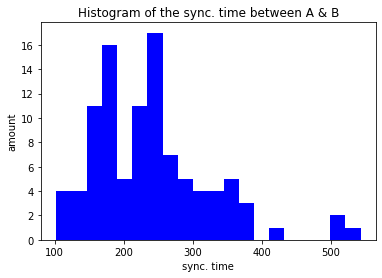

In [ ]:
plt.figure()
plt.hist(data['sync_time'], color = "blue", bins = 20)
plt.title('Histogram of the sync. time between A & B')
plt.xlabel("sync. time")
plt.ylabel("amount")
plt.plot()

We want to see that Eve didn't succeed to converge faster than Alice and Bob:

[]

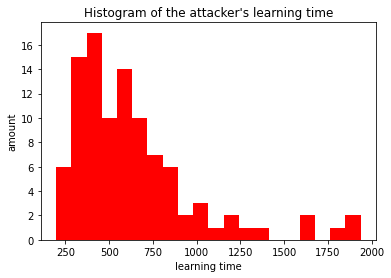

In [ ]:
plt.hist(data['attacker_time'], color = "red",  bins = 20)
plt.title("Histogram of the attacker's learning time")
plt.xlabel("learning time")
plt.ylabel("amount")
plt.plot(c = 'red')

Actually, more importantly than the number of steps until convergence is **the ratio** between the attacker time and the synchronization time.

 The average ratio between the attacker learning time and the synchronization time is 2.901 with std of 2.137
 The minimal ratio  is 1.194


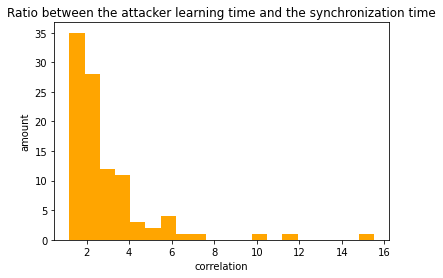

In [ ]:
ratio_attack_sync = [i/j for i, j in zip(data['attacker_time'], data['sync_time'])]
data['ratio_attack_sync'] = ratio_attack_sync

plt.figure()
plt.hist(ratio_attack_sync, color = "orange", bins = 20)
plt.title('Ratio between the attacker learning time and the synchronization time')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average ratio between the attacker learning time and the synchronization time is {np.mean(ratio_attack_sync):.3f} with std of {np.std(ratio_attack_sync):.3f}")
print(f" The minimal ratio  is {np.min(ratio_attack_sync):.3f}")

One can say that maybe if we know the initial state of Alice's weights we can evaluate where she will end.
<br> Therefore, we calculate the correlation between Alice's initial and her final weights:

 The average correlation between Alice's initial and final weights is -0.015 steps with std of 0.167


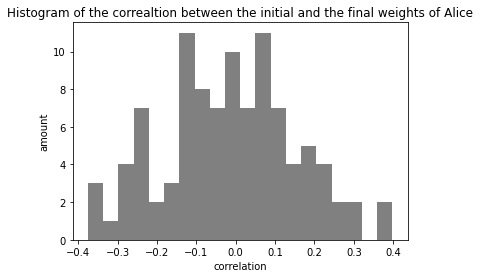

In [ ]:
plt.figure()
plt.hist(data['corr_alice'], color = "grey", bins = 20)
plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average correlation between Alice's initial and final weights is {np.mean(data['corr_alice']):.3f} steps with std of {np.std(data['corr_alice']):.3f}")

### currently it is not working (after adding 'data'):
The following graphs confirm the assumption that as the correlation between Alice's and Bob's weights higher, the probability to get the same output is higher.

In [ ]:
# sliding window
window_size = 50
chance = []
for i in range(len(data['when_move'])-window_size+1):
    chance.append(data[0]['when_move'][i, i + window_size].sum()/window_size)

plt.figure()
plt.title('The probability to take a step vs. time')
plt.xlabel("time")
plt.ylabel("probability")
plt.plot(range(len(chance)), chance, c = 'green')
plt.scatter(int(sync_time[0, -1]), chance[int(sync_time[0, -1])], c = 'red', s = 10, linewidth = 5)

In [ ]:
len(data['when_move'])

63828

In [ ]:
summ = 0
sum(data['attacker_time'])


63828

In [ ]:
print(summ)

NameError: ignored

The correlation between Alice and Bob vs Alice and Eve over the learing time

In [ ]:
# plt.figure()
# plt.hist(np.resize(corr_alice_bob, (num_sys,)), color = "grey", bins = 20)
# plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
# plt.xlabel("correlation")
# plt.ylabel("amount")
# plt.plot()

# print(f" The average correlation between Alice's initial and final weights is {np.mean(corr_alice):.3f} steps with std of {np.std(corr_alice):.3f}")

In [ ]:
def entropy_calc(arr):
  

In [ ]:
print(data[0]['when_move'][0:6])

### Graphs we want to show:
1. Histogram of the synchronization time between Alice and bob. --- done!
2. The chance of A&B to take a step (sliding window) --- done! (I think...)
3. The correlation between A&B over the learning time (vs. the attacker's correlation)
4. Show how the sync time depends on the constants (N, L, K)- "errorbar"
5. To show that the final weights are not correlated to the initial weights.
6. examine how inputs in [-M, M] affects the information we can get from the final weights.